## Early Detection of Sepsis
Goal: Detection of Sepsis ICD9 Codes using clincal labs as a data source
for hosptial Inpatients 
#### Goals
Demontraction of AutoML 
evalML pypi packages that automatically builds ML models and feature extaction pipelines
[https://www.alteryx.com/innovation-labs]
#### Author:
Matthew Davis
#### Data Source:
Physio MIMIC III v 1.4



In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_validate,  StratifiedKFold
from sklearn.metrics import *
from evalml.automl import AutoMLSearch
import evalml
import os
import re
import mlflow
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
MAX_MEMORY = "12g"
data_dir = os.getenv('PHYSIO_HOME')

In [3]:

# creates the spark context 
spark = SparkSession.builder \
    .appName("EarlyDectionOfSepsis") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()


#### Data Loading
Loads data as from as spark data frames from physio MIMIC III

Data is saves as CSV files, loaded is individual tables

In [4]:

## read in admissions data and using Hospital Expired Flag as an Outcome 
path = data_dir + '/' + 'ADMISSIONS.csv'
admissions = spark.read.csv(path, header=True, inferSchema=True)
admissions = admissions.withColumn('HOSPITAL_EXPIRE_FLAG', col('HOSPITAL_EXPIRE_FLAG').cast(IntegerType()))
admissions = admissions.withColumn('HADM_ID', col('HADM_ID').cast(IntegerType()))

path = data_dir + '/' + 'DIAGNOSES_ICD.csv'
dx =  spark.read.csv(path, header=True, inferSchema=True)

path = data_dir + '/'  'DRGCODES.csv'
drg =  spark.read.csv(path, header=True, inferSchema=True)

path = data_dir + '/' + 'PATIENTS.csv'
pats =  spark.read.csv(path, header=True, inferSchema=True)

path = data_dir + '/' +  'D_LABITEMS.csv'
labs_dim = spark.read.csv(path, header=True, inferSchema=True)

path = data_dir + '/' + 'LABEVENTS.csv'
labs = spark.read.csv(path, header=True, inferSchema=True).join(labs_dim, on ='ITEMID', how='inner')

### Data Labeling 
###### Cases 
Hosptial Encounters with Emergency or Urgent admission type that have a diagnoses ICD9 code of 99592 (Sepsis), that had length of stay between 1 and 5 day, age 2 and over (at time of admissions)


###### Controls 
Hosptial Encounters with Emergency or Urgent admission type that DO NOT have a diagnoses ICD9 code of 99592 (Sepsis), that had length of stay between 1 and 5 day, age 2 and over (at time of admissions) 
and have been discharge home or to home health care, and did not expire in the hospital.

#### Feature Engineering
Extracts from CSVs from physio MIMIC III a datasets based on the first
lab value a patient recieves

Data is oragnized by LOINC Codes

Data is aggregated to the graine of HADM_ID (Hospital Admission ID), features are lab aggregated to the first lab value during the encounter

Only short encounters are used, between 1-5 days since it supission of sepsis is often a likely reason for admission


In [16]:

## Extracts the Top Features, by overall counts of number of times features are non null
n_features = 400
top_features  = labs\
.filter('LOINC_CODE is not Null')\
.filter('VALUENUM is not Null')\
.groupby('LOINC_CODE')\
.agg(count('LOINC_CODE').alias('count'),first("LABEL").alias("LABEL"))\
.sort('count', ascending=False)\
.limit(n_features).drop('count')

## create a lookup dictionary for LoinCodes, for future references
loinc_lookup = top_features.toPandas().set_index('LOINC_CODE')

## Finds the First Feature, that occured furing a Hosptial Stay
w = Window().partitionBy('HADM_ID', 'LABEL').orderBy(col('CHARTTIME').cast(LongType()))

print(F'collecting {n_features } lab features')

## collect first labs and pivots 
lab_features = labs\
.filter('VALUENUM is not Null')\
.join(top_features.select('LOINC_CODE'), on='LOINC_CODE', how='inner')\
.withColumn('firstValue', first('VALUENUM').over(w))\
.groupby('HADM_ID')\
.pivot('LOINC_CODE')\
.agg(first('VALUENUM').cast(FloatType()))

## cases where sepsis occured
cases = dx.filter('ICD9_CODE like "99592%"')\
.groupby("HADM_ID")\
.agg(collect_set('ICD9_CODE'))\
.join(admissions, on='HADM_ID', how='inner')\
.filter(datediff(col('DISCHTIME'), col('ADMITTIME')) <=5)\
.filter(datediff(col('DISCHTIME'), col('ADMITTIME')) >=1)\
.filter('ADMISSION_TYPE in ("EMERGENCY", "URGENT")')\
.filter('HAS_CHARTEVENTS_DATA == 1')\
.join(pats, on='SUBJECT_ID',how='inner')\
.withColumn('ageAtAdmit', datediff('ADMITTIME','DOB')/365)\
.filter(col('ageAtAdmit') >=2 )\
.join(lab_features,  on='HADM_ID', how='inner' )

# cases where sepsis did not occure and the patient was discharged home
controls =  dx.filter('ICD9_CODE not like "99592%"')\
.groupby("HADM_ID")\
.agg(collect_set('ICD9_CODE'))\
.join(admissions, on='HADM_ID', how='inner')\
.filter(datediff(col('DISCHTIME'), col('ADMITTIME')) <=5)\
.filter(datediff(col('DISCHTIME'), col('ADMITTIME')) >=1)\
.filter('DISCHARGE_LOCATION in ("HOME", "HOME HEALTH CARE")')\
.filter('ADMISSION_TYPE in ("EMERGENCY", "URGENT")')\
.filter('DIAGNOSIS not like "%SEPSI%"')\
.filter('HAS_CHARTEVENTS_DATA == 1')\
.filter('HOSPITAL_EXPIRE_FLAG == 0')\
.join(pats, on='SUBJECT_ID',how='inner')\
.withColumn('ageAtAdmit', datediff('ADMITTIME','DOB')/365)\
.filter(col('ageAtAdmit') >=2 )\
.join(lab_features,  on='HADM_ID', how='inner' )

# prints statistics 
n_cases = cases.count()
n_controls = controls.count()
print(F'n_cases: {n_cases}')
print(F'n_controls: {n_controls}')

collecting 400 lab features


n_cases: 879
n_controls: 9598


In [14]:
cases_df = cases.select(*lab_features.columns).toPandas().set_index('HADM_ID')
controls_df = controls.select(*lab_features.columns ).toPandas().set_index('HADM_ID')

In [17]:
df = pd.concat([cases_df, controls_df], axis=0)

X = df.values
y = np.concatenate([np.ones(cases_df.shape[0]) , np.zeros(controls_df.shape[0])])
assert y.shape[0] == X.shape[0]

n_rows = X.shape[0]
n_features = X.shape[1]

label_prob = y.mean()
feature_names_all = df.columns
print(F' n_rows: {n_rows}, n_features: {n_features}, label_prob {np.round(label_prob , 3)}')
assert X.shape[0] == y.shape[0]

data_stats_path = 'data_stats.csv'
data_stats = df.describe()
data_stats.to_csv(data_stats_path)
data_stats 

 n_rows: 10477, n_features: 307, label_prob 0.084


,10330-9,10334-1,10346-5,10535-3,10548-6,10839-9,11031-2,11153-4,11555-0,11556-8,...,8128-1,8129-9,8132-3,8137-2,8138-0,8247-9,9322-9,9618-0,9619-8,9842-6
count,173.000000,23.000000,15.000000,277.000000,15.000000,179.000000,173.000000,55.000000,4303.000000,4300.000000,...,53.00000,46.000000,0.0,46.000000,46.000000,0.0,1462.000000,11.000000,5.000000,5.00000
mean,10.774567,167.334793,88.886673,1.076534,18.066668,9.102793,27.890173,13.772727,-1.905880,158.324646,...,331.75473,0.730217,NaN,49.869564,625.673889,NaN,4.066689,57.000000,26.400000,1.40000
std,16.310614,304.802399,20.475834,0.807343,7.459095,12.534928,25.538719,12.068024,10.786492,124.290100,...,329.21991,0.946175,NaN,18.665010,554.100525,NaN,2.048182,33.787571,12.521981,1.67332
min,0.000000,4.000000,29.700001,0.200000,8.000000,0.300000,0.000000,2.000000,-413.000000,0.000000,...,6.00000,0.000000,NaN,9.000000,73.000000,NaN,1.100000,14.000000,13.000000,0.00000
25%,0.000000,12.000000,91.300003,0.600000,12.500000,0.800000,6.000000,4.750000,-4.000000,73.000000,...,121.00000,0.225000,NaN,38.750000,328.250000,NaN,2.900000,35.000000,17.000000,0.00000
50%,5.000000,23.000000,98.300003,0.900000,18.000000,3.400000,22.000000,9.000000,0.000000,108.000000,...,218.00000,0.400000,NaN,52.000000,489.500000,NaN,3.700000,57.000000,27.000000,1.00000
75%,13.000000,149.000000,100.000000,1.300000,19.500000,11.500000,43.000000,19.500000,1.000000,201.000000,...,428.00000,0.800000,NaN,61.000000,764.000000,NaN,4.700000,72.500000,30.000000,2.00000
max,84.000000,1249.000000,100.000000,5.700000,35.000000,49.900002,94.000000,45.500000,36.000000,617.000000,...,1466.00000,5.100000,NaN,93.000000,2876.000000,NaN,31.600000,132.000000,45.000000,4.00000


### Data Splitting
Data was split using statified K fold splitting, into traing and test sets

### Feature Selection 
50 features were selected using recursive featoure exclusion with a decision tree classifier model

In [18]:
splitter = StratifiedKFold(shuffle=True)
train_index, test_index = next(splitter.split(X, y))

selector = RFE(DecisionTreeClassifier(), step=5, n_features_to_select=50)

#featuer selection via recussive feature elemination 
selector= selector.fit(df.iloc[train_index, :].fillna(0), y[train_index])

support_index = selector.get_support()
feature_names = feature_names_all[support_index]

X_train = df.iloc[train_index, :].loc[:, feature_names] 
X_test = df.iloc[test_index, :].loc[:, feature_names] 
y_train = y[train_index]
y_test = y[test_index]

feature_names = list(X_train.columns)
print(F'Selected Feature Names {feature_names}')

Selected Feature Names ['11557-6', '1742-6', '1751-7', '1920-8', '1963-8', '1988-5', '1994-3', '19994-3', '2000-8', '20564-1', '20578-1', '2075-0', '2093-3', '2143-6', '2157-6', '2160-0', '2345-7', '2532-0', '2601-3', '2823-3', '2951-2', '3016-3', '3094-0', '3095-7', '3173-2', '3255-7', '32693-4', '40517-5', '5797-6', '5804-0', '5811-5', '5818-0', '5821-4', '5895-7', '5902-2', '6598-7', '6768-6', '6773-6', '711-2', '718-7', '731-0', '742-7', '761-7', '763-3', '777-3', '785-6', '787-2', '788-0', '789-8', '804-5']


#### Auto ML
Modeling finds the best model / feature extraction pipeline using AutoML

In [19]:
automl = AutoMLSearch(X_train=X_train, y_train=y_train, problem_type='binary')
with  warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    automl.search()
model = automl.best_pipeline

Using default limit of max_batches=1.

Generating pipelines to search over...
8 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: xgboost, lightgbm, catboost, random_forest, extra_trees, linear_model, decision_tree



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 2.897

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Imputer + SMOTE Oversampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.208
Decision Tree Classifier w/ Imputer + SMOTE Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.415
Random Forest Classifier w/ Imputer + SMOTE Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.168
LightGBM Classifier w/ Imputer + SMOTE Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.158
Logistic Regression Classifier w/ Imputer + SMOTE Oversampler + Standard Scaler:
	Starting cross validation
	Finished cross vali

#### Model Analysis
Calculates Model Metrics and Signatures for tracking with MLlfow

In [20]:
from mlflow.models.signature import infer_signature

# predicts the test data
test_preds = model.predict_proba(X_test).iloc[:, 1]
test_pred_labels = model.predict(X_test)

# calcuates metrics on test data
test_f1 = f1_score(y_test, test_pred_labels)
print(F'test_f1: {test_f1}')
test_acc_balanced = balanced_accuracy_score(y_test, test_pred_labels)
print(F'test_acc_balanced: {test_acc_balanced}')
test_acc = accuracy_score(y_test, test_pred_labels)
test_precision = precision_score(y_test, test_pred_labels)
print(F'test_precision: {test_precision}')
test_recall = recall_score(y_test, test_pred_labels)
print(F'test_recall: {test_recall}')
test_auc_score = roc_auc_score(y[test_index], test_preds)
print(F'test roc_auc_score: {test_auc_score }')

## predicts the training data 
train_preds = model.predict_proba(X_train).iloc[:, 1]
train_pred_labels = model.predict(X_train)

# calculates metrics on training data 
train_f1 = f1_score(y_train, train_pred_labels)
train_acc_balanced = balanced_accuracy_score(y_train, train_pred_labels)
train_acc = accuracy_score(y_train, train_pred_labels)
train_precision = precision_score(y_train, train_pred_labels)
train_recall = recall_score(y_train, train_pred_labels)
train_auc_score = roc_auc_score(y_train, train_preds)
print(F'train roc_auc_score: {train_auc_score}')

# gets params Artifacts for logging mlflow model
n_cases = np.sum(y == 1)
n_controls = np.sum(y == 0)
n_train_obs = X_train.shape[0]
n_test_obs = X_test.shape[0]
n_features = X_train.shape[1]
train_label_prob = y_train.mean()
test_label_prob = y_test.mean()
desc = str(model.describe())
model_type = type(model)
split_type = type(splitter)
input_example = X_train.head().fillna(0)
signature = infer_signature(X_train.head().fillna(0), model.predict_proba(X_train.head().fillna(0)))

test_f1: 0.5714285714285715
test_acc_balanced: 0.760440340909091
test_precision: 0.5868263473053892
test_recall: 0.5568181818181818
test roc_auc_score: 0.952645596590909
train roc_auc_score: 0.9912862746899844

*****************************************************
* XGBoost Classifier w/ Imputer + SMOTE Oversampler *
*****************************************************

Problem Type: binary
Model Family: XGBoost
Number of features: 50

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. SMOTE Oversampler
	 * sampling_ratio : 0.25
	 * k_neighbors_default : 5
	 * n_jobs : -1
	 * sampling_ratio_dict : None
	 * k_neighbors : 5
3. XGBoost Classifier
	 * eta : 0.1
	 * max_depth : 6
	 * min_child_weight : 1
	 * n_estimators : 100


### Feature Importance

Information Gain Based Feature Importance

<AxesSubplot:>

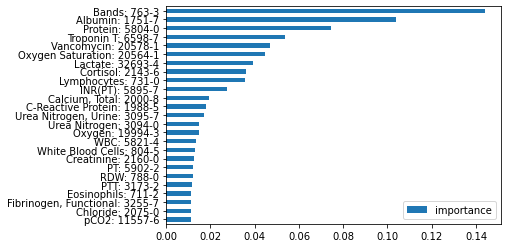

In [21]:
import json
imp = model.feature_importance.set_index('feature')
imp.index = [loinc_lookup.loc[key][0] + ': ' +key  for key in imp.index]


# dumps feature importance to a dictionary for logging as an artifact
imp_dict = imp.to_dict()['importance']


imp_json_path = 'feature_importance.json'
with open(imp_json_path, 'w') as f:
    json.dump(imp_dict,f)

imp.head(25).sort_values( by='importance', ascending=True).plot.barh()